In [1]:
import matplotlib.pyplot as plt
import torch
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from kan import *

# 1. Heat Dynamic

In [62]:
def heat_dynamic(seed):
    # create heat dynamic F+G  [5,10,20,50]
    f = None
    g = lambda x: -0.1 * (x[:, [0]] - x[:, [1]])
    dataset = create_dataset(g, n_var=2, ranges=[0, 5], seed=seed)
    test_dataset = create_dataset(g, n_var=2, ranges=[0, 10], seed=seed)
    
    # 定义KAN模型
    grids = np.array([5, 10, 20, 50])  # ,100
    train_losses = []
    test_losses = []
    steps = 50
    k = 3
    for i in range(grids.shape[0]):
        if i == 0:
            model = KAN(width=[2,1], grid=grids[i], k=k, seed=seed)
        if i != 0:
            model = KAN(width=[2,1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])
        results = model.train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)  # default=30
        train_losses += results['train_loss']
        test_losses += results['test_loss']

    train_pred = model(dataset['train_input'])
    test_pred = model(test_dataset['test_input'])
    loss_fn = lambda x, y: torch.mean((x - y) ** 2)
    train_loss = torch.sqrt((loss_fn(train_pred, dataset['train_label'])))
    test_loss = torch.sqrt((loss_fn(test_pred, test_dataset['test_label'])))
    print('KAN : Train loss: ', train_loss.item(), ', Test loss: ', test_loss.item())

    # 定义 MLPRegressor 模型
    model_mlp = MLPRegressor(hidden_layer_sizes=(64, 64), activation='relu', solver='adam', max_iter=2000, random_state=0)
    model_mlp.fit(dataset['train_input'].cpu(), dataset['train_label'].cpu().ravel())
    train_pred_mlp = model_mlp.predict(dataset['train_input'].cpu())
    test_pred_mlp = model_mlp.predict(test_dataset['test_input'].cpu())
    loss_fn = lambda x, y: torch.mean((x - y) ** 2)
    train_loss = torch.sqrt((loss_fn(torch.tensor(train_pred_mlp).cuda(), dataset['train_label'])))
    test_loss = torch.sqrt((loss_fn(torch.tensor(test_pred_mlp).cuda(), test_dataset['test_label'])))
    print('MLP : Train loss: ', train_loss.item(), ', Test loss: ', test_loss.item())

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=100)
    ax1.plot(train_losses)
    ax1.plot(test_losses)
    ax1.legend(['Train loss', 'Test loss'])
    ax1.set_xlabel('step')
    ax1.set_ylabel('RMSE')
    ax1.set_yscale('log')
    ax1.set_title('KAN-loss')

    ax2.scatter(test_dataset['test_label'].cpu(), test_pred.cpu().detach().numpy(), marker='o', color='b')
    ax2.scatter(dataset['train_label'].cpu(), train_pred.cpu().detach().numpy(), marker='x', color='r')
    ax2.set_xlabel('label')
    ax2.set_ylabel('predict')
    ax2.set_title('KAN-extent')

    ax3.scatter(test_dataset['test_label'].cpu(), test_pred_mlp, marker='o', color='b')
    ax3.scatter(dataset['train_label'].cpu(), train_pred_mlp, marker='x', color='r')
    ax3.set_xlabel('label')
    ax3.set_ylabel('predict')
    ax3.set_title('MLP')
    plt.show()
    
    
    fig2, (ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), dpi=100)
    # 创建网格数据
    x = np.linspace(0, 10, 100)
    y = np.linspace(0, 10, 100)
    X_grid, Y_grid = np.meshgrid(x, y)
    # 计算每个网格点的输出值 Z
    grid_points = np.c_[X_grid.ravel(), Y_grid.ravel()]
    grid_points_torch = torch.tensor(grid_points, dtype=torch.float32)
    Z1 = g(grid_points_torch).numpy().reshape(X_grid.shape)
    Z2 = model(grid_points_torch.to("cuda")).cpu().detach().numpy().reshape(X_grid.shape)
    Z3 = model_mlp.predict(grid_points_torch.cpu()).reshape(X_grid.shape)
    contour1 = ax4.contourf(X_grid, Y_grid, Z1, levels=50, cmap='viridis', vmin=Z1.min(), vmax=Z1.max())
    ax4.set_title('True')
    contour2 = ax5.contourf(X_grid, Y_grid, Z2, levels=50, cmap='viridis', vmin=Z1.min(), vmax=Z1.max())
    ax5.set_title('KAN')
    contour3 = ax6.contourf(X_grid, Y_grid, Z3, levels=50, cmap='viridis', vmin=Z1.min(), vmax=Z1.max())
    ax6.set_title('MLP')
    # 添加一个共享的颜色条
    cbar = fig2.colorbar(contour2, ax=[ax4, ax5, ax6], location='right', shrink=1)
    plt.show()
    

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

[1730, 789, 1553, 1824, 862, 83, 531, 1978, 1048, 996]


train loss: 2.69e-05 | test loss: 2.75e-05 | reg: 2.10e+00 : 100%|██| 50/50 [00:07<00:00,  7.02it/s]
train loss: 1.36e-06 | test loss: 1.50e-06 | reg: 2.10e+00 : 100%|██| 50/50 [00:05<00:00,  9.05it/s]
train loss: 3.80e-07 | test loss: 3.81e-07 | reg: 2.10e+00 : 100%|██| 50/50 [00:03<00:00, 16.33it/s]
train loss: 1.06e-07 | test loss: 1.24e-07 | reg: 2.10e+00 : 100%|██| 50/50 [00:03<00:00, 13.72it/s]


KAN : Train loss:  1.0620774304470615e-07 , Test loss:  0.029341142624616623
MLP : Train loss:  0.2830442053867943 , Test loss:  0.5907771533313755


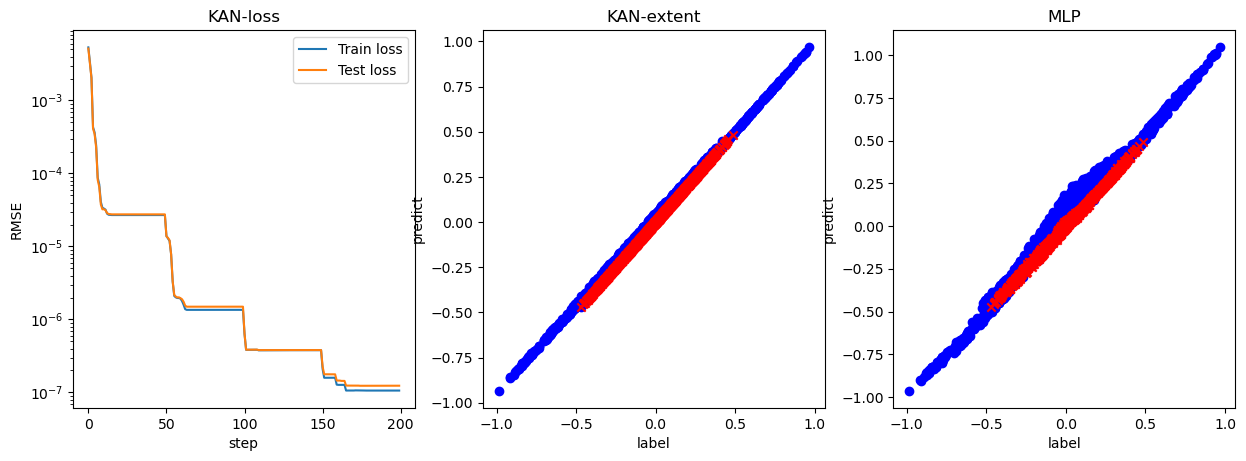

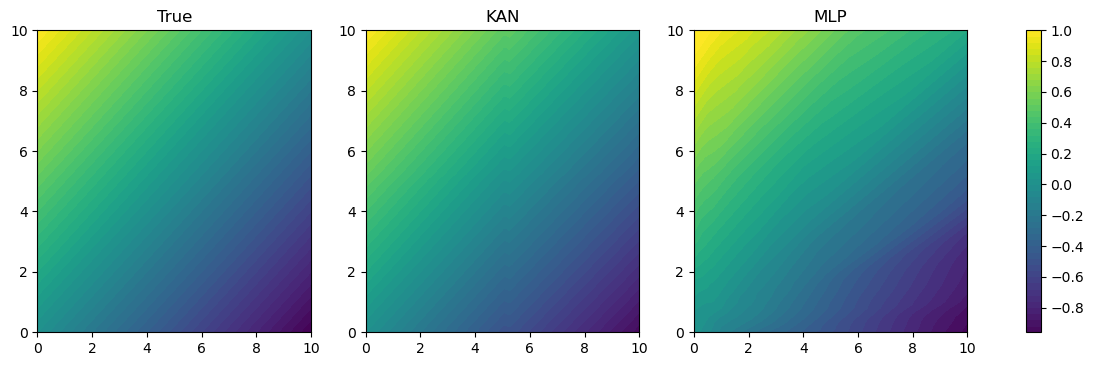

train loss: 3.07e-05 | test loss: 2.94e-05 | reg: 2.08e+00 : 100%|██| 50/50 [00:05<00:00,  8.58it/s]
train loss: 2.21e-06 | test loss: 2.38e-06 | reg: 2.08e+00 : 100%|██| 50/50 [00:04<00:00, 10.48it/s]
train loss: 8.17e-07 | test loss: 7.35e-07 | reg: 2.08e+00 : 100%|██| 50/50 [00:04<00:00, 12.16it/s]
train loss: 1.82e-07 | test loss: 1.71e-07 | reg: 2.08e+00 : 100%|██| 50/50 [00:04<00:00, 12.31it/s]


KAN : Train loss:  1.8166747395298444e-07 , Test loss:  0.12755517661571503
MLP : Train loss:  0.2976326335757156 , Test loss:  0.5793409660610648


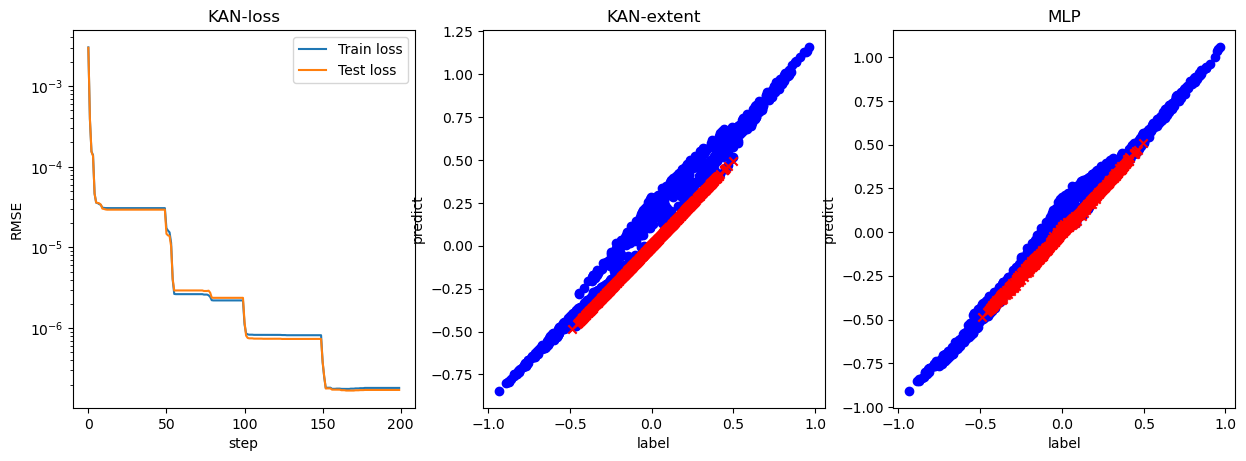

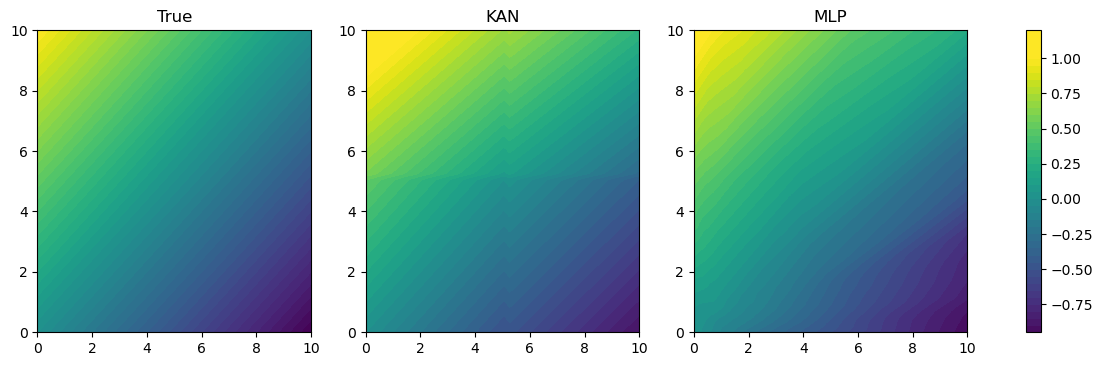

train loss: 2.65e-05 | test loss: 2.62e-05 | reg: 2.05e+00 : 100%|██| 50/50 [00:05<00:00,  8.88it/s]
train loss: 1.42e-06 | test loss: 1.38e-06 | reg: 2.05e+00 : 100%|██| 50/50 [00:05<00:00,  8.94it/s]
train loss: 4.56e-07 | test loss: 4.04e-07 | reg: 2.05e+00 : 100%|██| 50/50 [00:04<00:00, 11.78it/s]
train loss: 4.58e-07 | test loss: 4.10e-07 | reg: 2.05e+00 : 100%|██| 50/50 [00:01<00:00, 28.22it/s]


KAN : Train loss:  4.5849293428545934e-07 , Test loss:  0.12400680780410767
MLP : Train loss:  0.29203019387861895 , Test loss:  0.5896772321694711


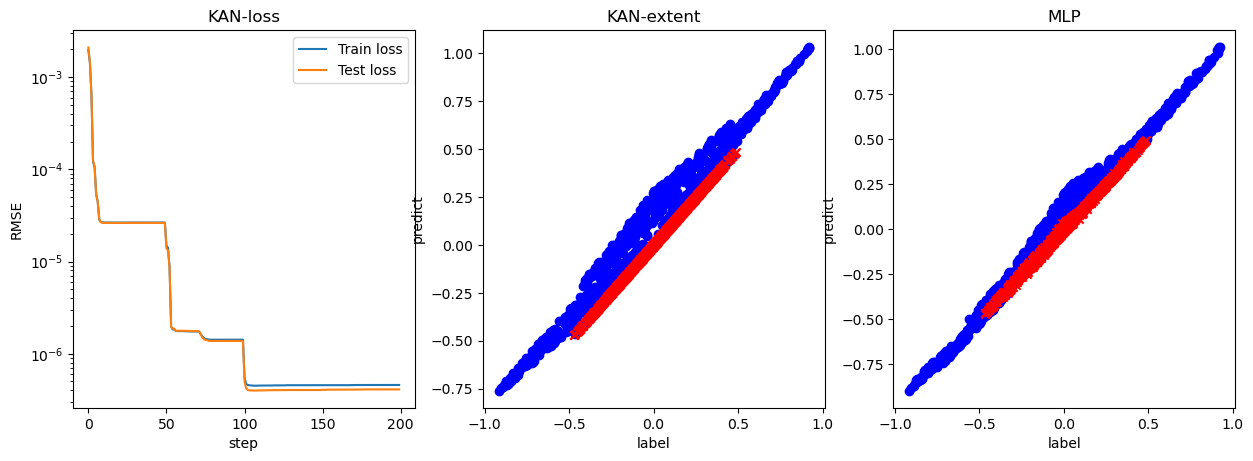

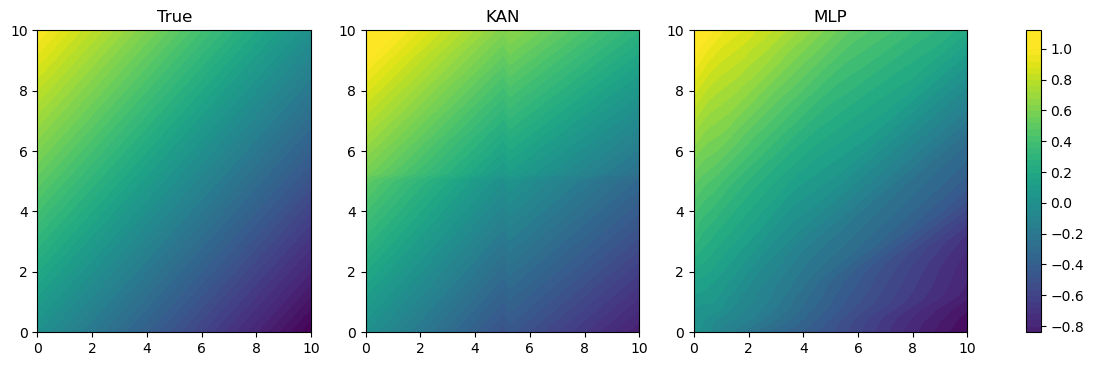

In [63]:
seeds = [random.randint(1, 2024) for _ in range(10)]
print(seeds)
for i in range(3):
    heat_dynamic(seeds[i])

# 2.biochemical dynamic

In [58]:
def biochemical_dynamic(seed):
    # create biochemical dynamic F+G  [5,10,20,50]
    f = lambda x: 1-0.1 * x[:, [0]]
    g = lambda x: 0.01 * x[:, [0]] * x[:, [1]]
    dataset = create_dataset(g, n_var=2, ranges=[0, 5], seed=seed)
    test_dataset = create_dataset(g, n_var=2, ranges=[0, 10], seed=seed)
    
    # 定义KAN模型
    grids = np.array([5, 10, 20])  # ,100
    train_losses = []
    test_losses = []
    steps = 50
    k = 3
    for i in range(grids.shape[0]):
        if i == 0:
            model = KAN(width=[2,2,1,1], grid=grids[i], k=k, seed=seed)
        if i != 0:
            model = KAN(width=[2,2,1,1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])
        results = model.train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)  # default=30
        train_losses += results['train_loss']
        test_losses += results['test_loss']
    
    train_pred = model(dataset['train_input'])
    test_pred = model(test_dataset['test_input'])
    loss_fn = lambda x, y: torch.mean((x - y) ** 2)
    train_loss = torch.sqrt((loss_fn(train_pred, dataset['train_label'])))
    test_loss = torch.sqrt((loss_fn(test_pred, test_dataset['test_label'])))
    print('KAN : Train loss: ', train_loss.item(), ', Test loss: ', test_loss.item())

    # 定义 MLPRegressor 模型
    model_mlp = MLPRegressor(hidden_layer_sizes=(128, 128), activation='relu', solver='adam', max_iter=2000, random_state=0)
    model_mlp.fit(dataset['train_input'].cpu(), dataset['train_label'].cpu().ravel())
    train_pred_mlp = model_mlp.predict(dataset['train_input'].cpu())
    test_pred_mlp = model_mlp.predict(test_dataset['test_input'].cpu())
    loss_fn = lambda x, y: torch.mean((x - y) ** 2)
    train_loss = torch.sqrt((loss_fn(torch.tensor(train_pred_mlp).cuda(), dataset['train_label'])))
    test_loss = torch.sqrt((loss_fn(torch.tensor(test_pred_mlp).cuda(), test_dataset['test_label'])))
    print('MLP : Train loss: ', train_loss.item(), ', Test loss: ', test_loss.item())

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=100)
    ax1.plot(train_losses)
    ax1.plot(test_losses)
    ax1.legend(['Train loss', 'Test loss'])
    ax1.set_xlabel('step')
    ax1.set_ylabel('RMSE')
    ax1.set_yscale('log')
    ax1.set_title('KAN-loss')

    ax2.scatter(test_dataset['test_label'].cpu(), test_pred.cpu().detach().numpy(), marker='o', color='b')
    ax2.scatter(dataset['train_label'].cpu(), train_pred.cpu().detach().numpy(), marker='x', color='r', alpha=0.5)
    # 添加 y = x 的直线
    x_vals = np.linspace(0, 1, 100)
    ax2.plot(x_vals, x_vals, linestyle='-', color='black', linewidth=2, label='y = x')
    ax2.set_xlabel('label')
    ax2.set_ylabel('predict')
    ax2.set_title('KAN-extent')

    ax3.scatter(test_dataset['test_label'].cpu(), test_pred_mlp, marker='o', color='b')
    ax3.scatter(dataset['train_label'].cpu(), train_pred_mlp, marker='x', color='r', alpha=0.5)
    # 添加 y = x 的直线
    x_vals = np.linspace(0, 1, 100)
    ax3.plot(x_vals, x_vals, linestyle='-', color='black', linewidth=2, label='y = x')
    ax3.set_xlabel('label')
    ax3.set_ylabel('predict')
    ax3.set_title('MLP')
    plt.show()
    
    fig2, (ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), dpi=100)
    # 创建网格数据
    x = np.linspace(0, 10, 100)
    y = np.linspace(0, 10, 100)
    X_grid, Y_grid = np.meshgrid(x, y)
    # 计算每个网格点的输出值 Z
    grid_points = np.c_[X_grid.ravel(), Y_grid.ravel()]
    grid_points_torch = torch.tensor(grid_points, dtype=torch.float32)
    Z1 = g(grid_points_torch).numpy().reshape(X_grid.shape)
    Z2 = model(grid_points_torch.to("cuda")).cpu().detach().numpy().reshape(X_grid.shape)
    Z3 = model_mlp.predict(grid_points_torch.cpu()).reshape(X_grid.shape)
    contour1 = ax4.contourf(X_grid, Y_grid, Z1, levels=50, cmap='viridis', vmin=Z1.min(), vmax=Z1.max())
    ax4.set_title('True')
    contour2 = ax5.contourf(X_grid, Y_grid, Z2, levels=50, cmap='viridis', vmin=Z1.min(), vmax=Z1.max())
    ax5.set_title('KAN')
    contour3 = ax6.contourf(X_grid, Y_grid, Z3, levels=50, cmap='viridis', vmin=Z1.min(), vmax=Z1.max())
    ax6.set_title('MLP')
    # 添加一个共享的颜色条
    cbar = fig2.colorbar(contour2, ax=[ax4, ax5, ax6], location='right', shrink=1)
    plt.show()

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

[1730, 789, 1553, 1824, 862, 83, 531, 1978, 1048, 996]


train loss: 2.92e-04 | test loss: 2.99e-04 | reg: 6.04e+00 : 100%|██| 50/50 [00:22<00:00,  2.25it/s]
train loss: 9.66e-05 | test loss: 9.84e-05 | reg: 6.05e+00 : 100%|██| 50/50 [00:20<00:00,  2.43it/s]
train loss: 8.79e-05 | test loss: 9.51e-05 | reg: 6.05e+00 : 100%|██| 50/50 [00:16<00:00,  2.99it/s]


KAN : Train loss:  8.792345033725724e-05 , Test loss:  0.08987711369991302
MLP : Train loss:  0.08031840317282085 , Test loss:  0.25939602366369663


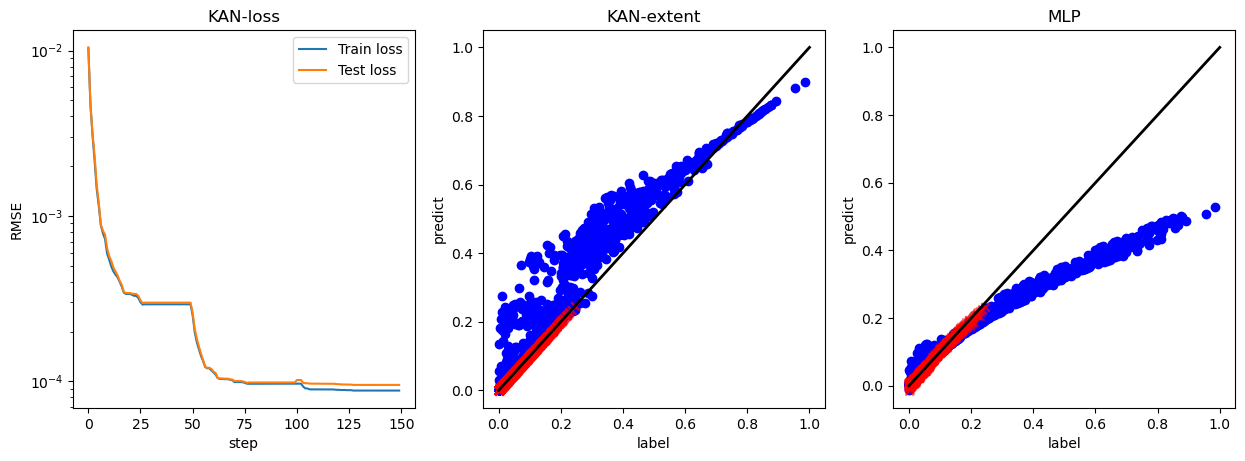

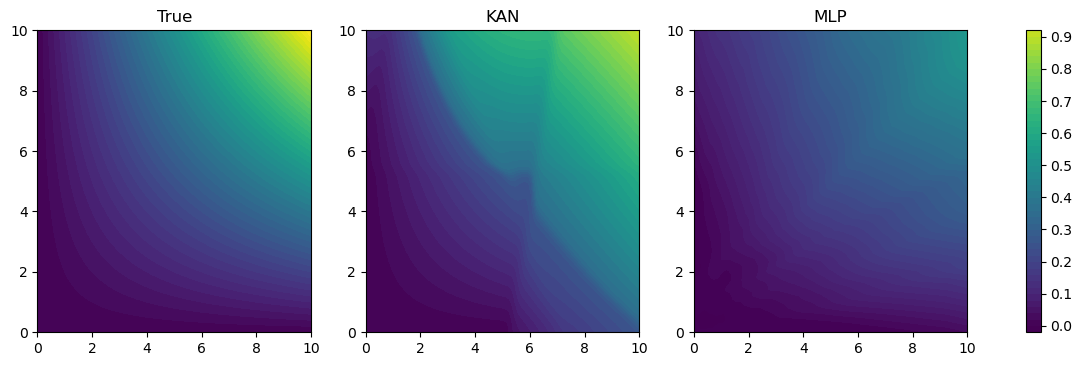

train loss: 1.55e-03 | test loss: 1.72e-03 | reg: 7.02e+00 : 100%|██| 50/50 [00:16<00:00,  2.99it/s]
train loss: 7.91e-04 | test loss: 7.46e-04 | reg: 7.00e+00 : 100%|██| 50/50 [00:19<00:00,  2.52it/s]
train loss: 5.79e-04 | test loss: 5.50e-04 | reg: 7.00e+00 : 100%|██| 50/50 [00:21<00:00,  2.32it/s]


KAN : Train loss:  0.0005789497517980635 , Test loss:  0.18362939357757568
MLP : Train loss:  0.07579485466720812 , Test loss:  0.26888194863630854


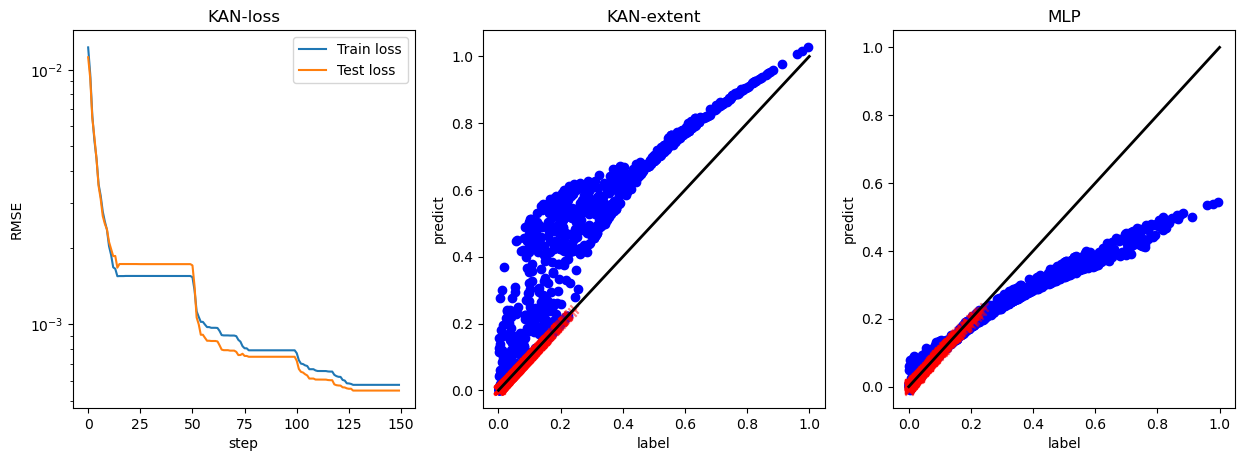

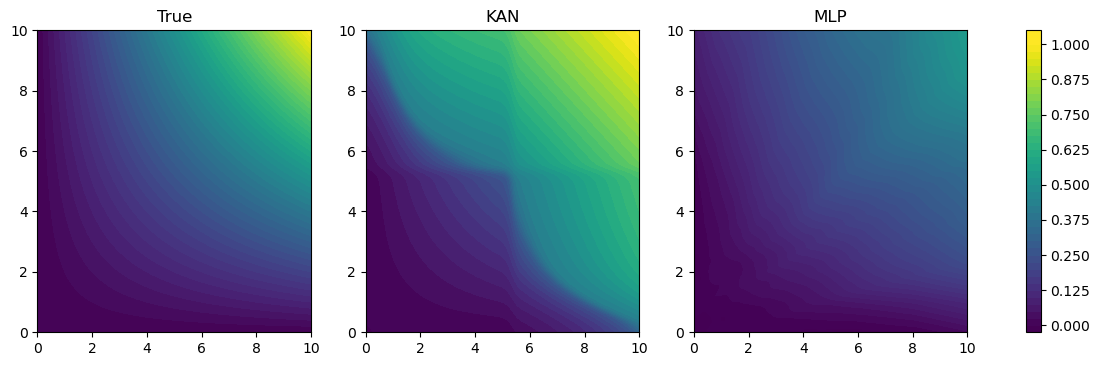

train loss: 3.15e-03 | test loss: 3.15e-03 | reg: 7.17e+00 : 100%|██| 50/50 [00:20<00:00,  2.41it/s]
train loss: 1.34e-03 | test loss: 1.45e-03 | reg: 7.28e+00 : 100%|██| 50/50 [00:23<00:00,  2.12it/s]
train loss: 1.13e-03 | test loss: 1.27e-03 | reg: 7.30e+00 : 100%|██| 50/50 [00:17<00:00,  2.94it/s]


KAN : Train loss:  0.0011265241773799062 , Test loss:  0.153818741440773
MLP : Train loss:  0.07973523413230893 , Test loss:  0.26831934857413675


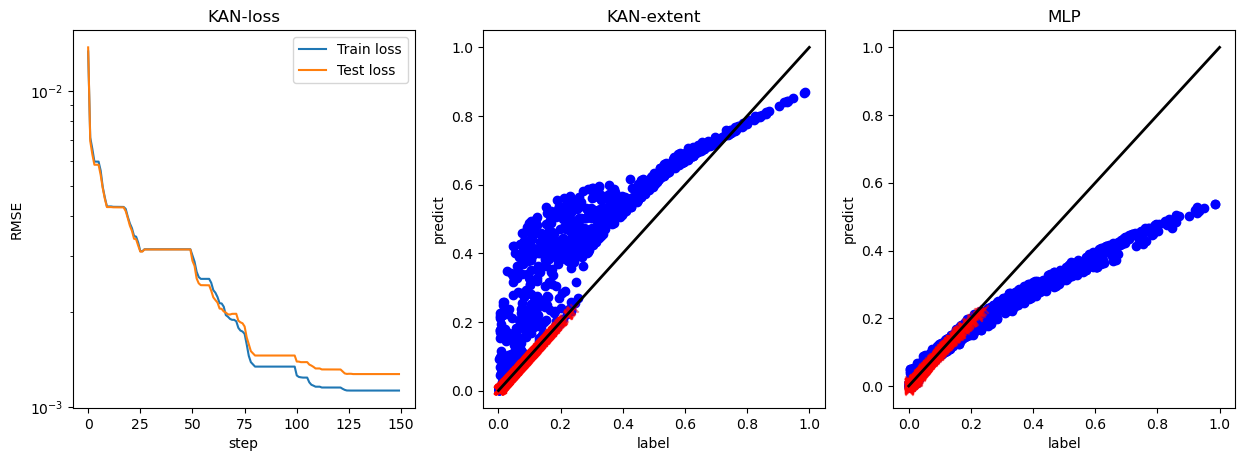

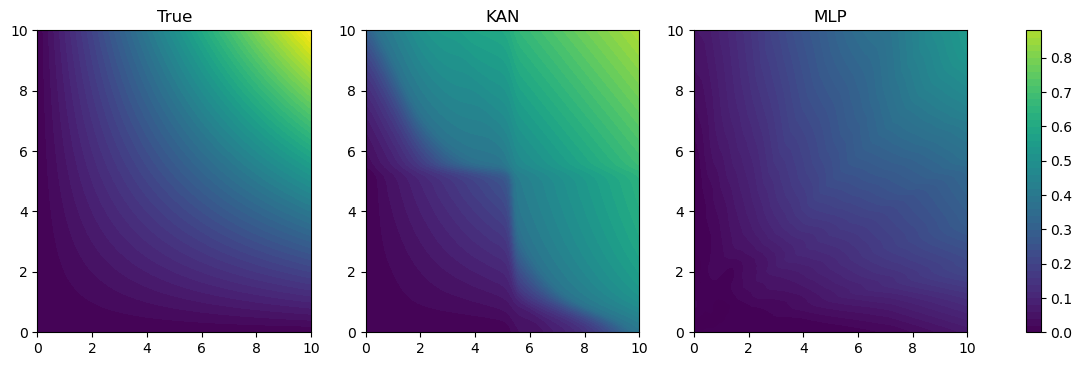

In [59]:
seeds = [random.randint(1, 2024) for _ in range(10)]
print(seeds)
for i in range(3):
    biochemical_dynamic(seeds[i])

# 3. birth Dynamic

In [70]:

def birth_dynamic(seed):
    # create birth dynamic F+G
    f = lambda x: -0.1 * x[:, [0]]**2
    g = lambda x: 0.2 * x[:, [1]]
    dataset = create_dataset(f, n_var=2, ranges=[0, 5], seed=seed)
    test_dataset = create_dataset(f, n_var=2, ranges=[0, 10], seed=seed)
    
    # 定义KAN模型
    grids = np.array([5, 10, 20, 30])  # ,100
    train_losses = []
    test_losses = []
    steps = 50
    k = 3
    for i in range(grids.shape[0]):
        if i == 0:
            model = KAN(width=[2,2,1], grid=grids[i], k=k, seed=seed)
        if i != 0:
            model = KAN(width=[2,2,1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])
        results = model.train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)  # default=30
        train_losses += results['train_loss']
        test_losses += results['test_loss']

    train_pred = model(dataset['train_input'])
    test_pred = model(test_dataset['test_input'])
    loss_fn = lambda x, y: torch.mean((x - y) ** 2)
    train_loss = torch.sqrt((loss_fn(train_pred, dataset['train_label'])))
    test_loss = torch.sqrt((loss_fn(test_pred, test_dataset['test_label'])))
    print('KAN : Train loss: ', train_loss.item(), ', Test loss: ', test_loss.item())

    # 定义 MLPRegressor 模型
    model_mlp = MLPRegressor(hidden_layer_sizes=(64, 64), activation='relu', solver='adam', max_iter=2000, random_state=0)
    model_mlp.fit(dataset['train_input'].cpu(), dataset['train_label'].cpu().ravel())
    train_pred_mlp = model_mlp.predict(dataset['train_input'].cpu())
    test_pred_mlp = model_mlp.predict(test_dataset['test_input'].cpu())
    loss_fn = lambda x, y: torch.mean((x - y) ** 2)
    train_loss = torch.sqrt((loss_fn(torch.tensor(train_pred_mlp).cuda(), dataset['train_label'])))
    test_loss = torch.sqrt((loss_fn(torch.tensor(test_pred_mlp).cuda(), test_dataset['test_label'])))
    print('MLP : Train loss: ', train_loss.item(), ', Test loss: ', test_loss.item())

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=100)
    ax1.plot(train_losses)
    ax1.plot(test_losses)
    ax1.legend(['Train loss', 'Test loss'])
    ax1.set_xlabel('step')
    ax1.set_ylabel('RMSE')
    ax1.set_yscale('log')
    ax1.set_title('KAN-loss')

    ax2.scatter(test_dataset['test_label'].cpu(), test_pred.cpu().detach().numpy(), marker='o', color='b')
    ax2.scatter(dataset['train_label'].cpu(), train_pred.cpu().detach().numpy(), marker='x', color='r', alpha=0.5)
    # 添加 y = x 的直线
    x_vals = np.linspace(-10, 0, 100)
    ax2.plot(x_vals, x_vals, linestyle='-', color='black', linewidth=2, label='y = x')
    ax2.set_xlabel('label')
    ax2.set_ylabel('predict')
    ax2.set_title('KAN-extent')

    ax3.scatter(test_dataset['test_label'].cpu(), test_pred_mlp, marker='o', color='b')
    ax3.scatter(dataset['train_label'].cpu(), train_pred_mlp, marker='x', color='r', alpha=0.5)
    # 添加 y = x 的直线
    x_vals = np.linspace(-10, 0, 100)
    ax3.plot(x_vals, x_vals, linestyle='-', color='black', linewidth=2, label='y = x')
    ax3.set_xlabel('label')
    ax3.set_ylabel('predict')
    ax3.set_title('MLP')
    plt.show()
    
    fig2, (ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), dpi=100)
    # 创建网格数据
    x = np.linspace(0, 10, 100)
    y = np.linspace(0, 10, 100)
    X_grid, Y_grid = np.meshgrid(x, y)
    # 计算每个网格点的输出值 Z
    grid_points = np.c_[X_grid.ravel(), Y_grid.ravel()]
    grid_points_torch = torch.tensor(grid_points, dtype=torch.float32)
    Z1 = f(grid_points_torch).numpy().reshape(X_grid.shape)
    Z2 = model(grid_points_torch.to("cuda")).cpu().detach().numpy().reshape(X_grid.shape)
    Z3 = model_mlp.predict(grid_points_torch.cpu()).reshape(X_grid.shape)
    contour1 = ax4.contourf(X_grid, Y_grid, Z1, levels=50, cmap='viridis', vmin=Z1.min(), vmax=Z1.max())
    ax4.set_title('True')
    contour2 = ax5.contourf(X_grid, Y_grid, Z2, levels=50, cmap='viridis', vmin=Z1.min(), vmax=Z1.max())
    ax5.set_title('KAN')
    contour3 = ax6.contourf(X_grid, Y_grid, Z3, levels=50, cmap='viridis', vmin=Z1.min(), vmax=Z1.max())
    ax6.set_title('MLP')
    # 添加一个共享的颜色条
    cbar = fig2.colorbar(contour2, ax=[ax4, ax5, ax6], location='right', shrink=1)
    plt.show()

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

[1730, 789, 1553, 1824, 862, 83, 531, 1978, 1048, 996]


train loss: 1.97e-04 | test loss: 2.03e-04 | reg: 4.06e+00 : 100%|██| 50/50 [00:24<00:00,  2.05it/s]
train loss: 3.84e-05 | test loss: 4.31e-05 | reg: 4.05e+00 : 100%|██| 50/50 [00:22<00:00,  2.20it/s]
train loss: 7.83e-06 | test loss: 1.14e-05 | reg: 4.05e+00 : 100%|██| 50/50 [00:20<00:00,  2.43it/s]
train loss: 5.54e-06 | test loss: 9.39e-06 | reg: 4.05e+00 : 100%|██| 50/50 [00:09<00:00,  5.45it/s]


KAN : Train loss:  5.543953193409834e-06 , Test loss:  1.927820086479187
MLP : Train loss:  1.0735637279090693 , Test loss:  3.5927211311437572


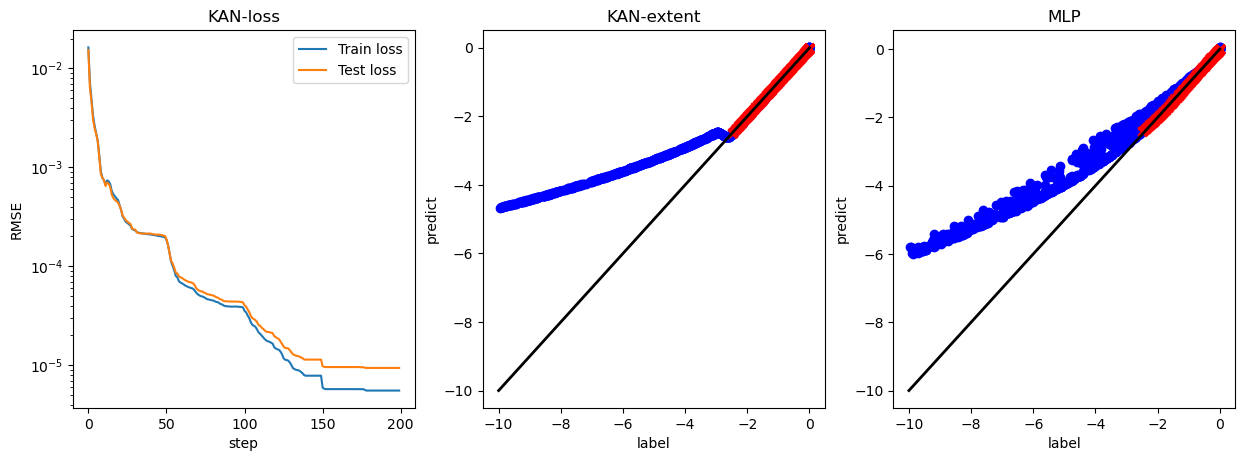

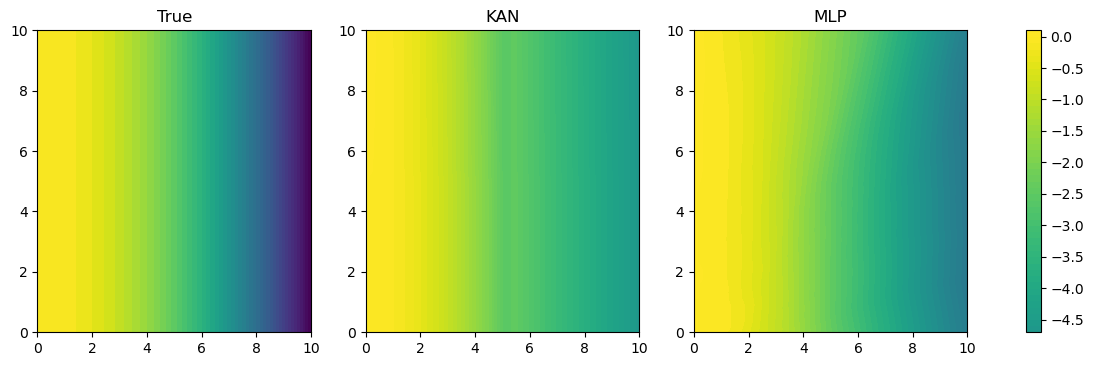

train loss: 1.54e-04 | test loss: 1.54e-04 | reg: 4.15e+00 : 100%|██| 50/50 [00:24<00:00,  2.07it/s]
train loss: 3.41e-05 | test loss: 3.57e-05 | reg: 4.16e+00 : 100%|██| 50/50 [00:20<00:00,  2.40it/s]
train loss: 7.02e-06 | test loss: 8.31e-06 | reg: 4.16e+00 : 100%|██| 50/50 [00:14<00:00,  3.53it/s]
train loss: 3.74e-06 | test loss: 5.39e-06 | reg: 4.16e+00 : 100%|██| 50/50 [00:10<00:00,  4.59it/s]


KAN : Train loss:  3.7411546145449392e-06 , Test loss:  1.874035120010376
MLP : Train loss:  1.040348739254713 , Test loss:  3.598488690303842


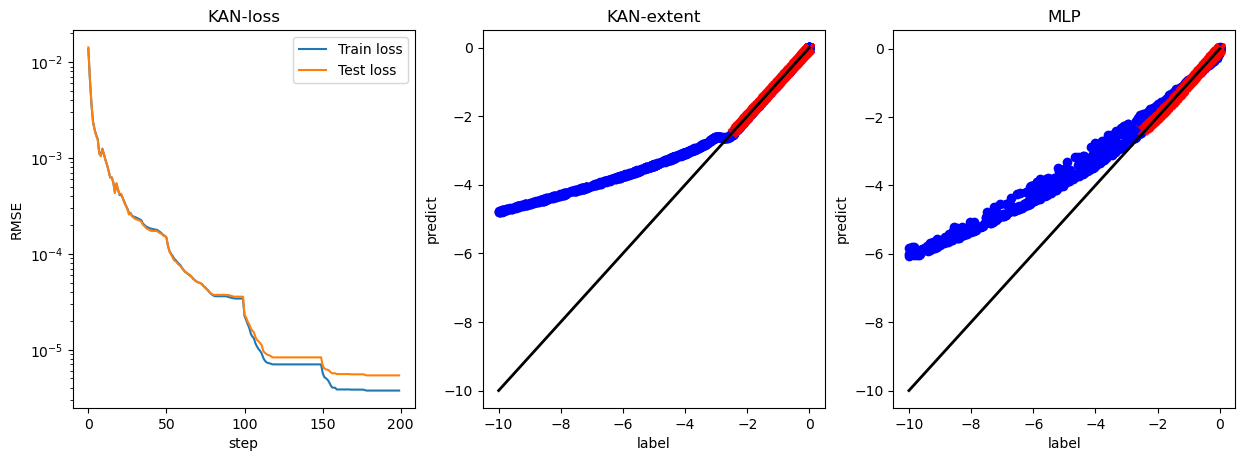

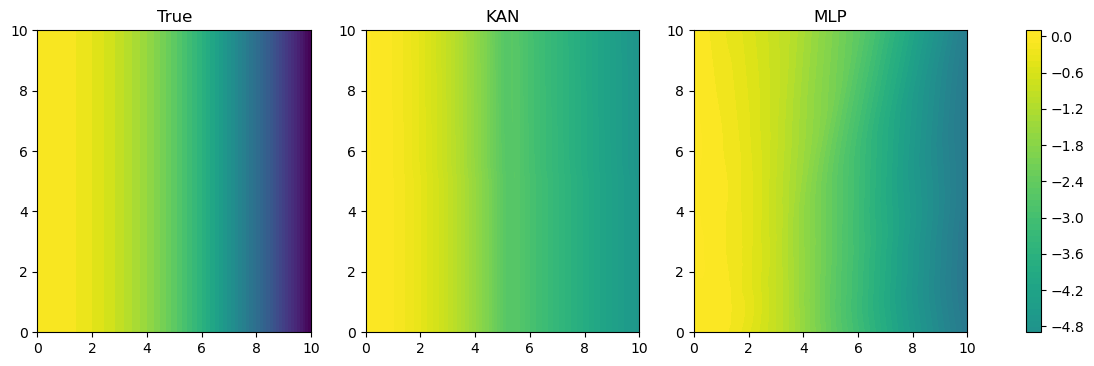

train loss: 8.93e-05 | test loss: 8.65e-05 | reg: 4.88e+00 : 100%|██| 50/50 [00:24<00:00,  2.06it/s]
train loss: 2.18e-05 | test loss: 2.32e-05 | reg: 4.89e+00 : 100%|██| 50/50 [00:15<00:00,  3.21it/s]
train loss: 9.12e-06 | test loss: 1.23e-05 | reg: 4.89e+00 : 100%|██| 50/50 [00:11<00:00,  4.29it/s]
train loss: 7.76e-06 | test loss: 1.11e-05 | reg: 4.89e+00 : 100%|██| 50/50 [00:10<00:00,  4.85it/s]


KAN : Train loss:  7.75740591052454e-06 , Test loss:  2.9908084869384766
MLP : Train loss:  1.0505156635131736 , Test loss:  3.6966833684328804


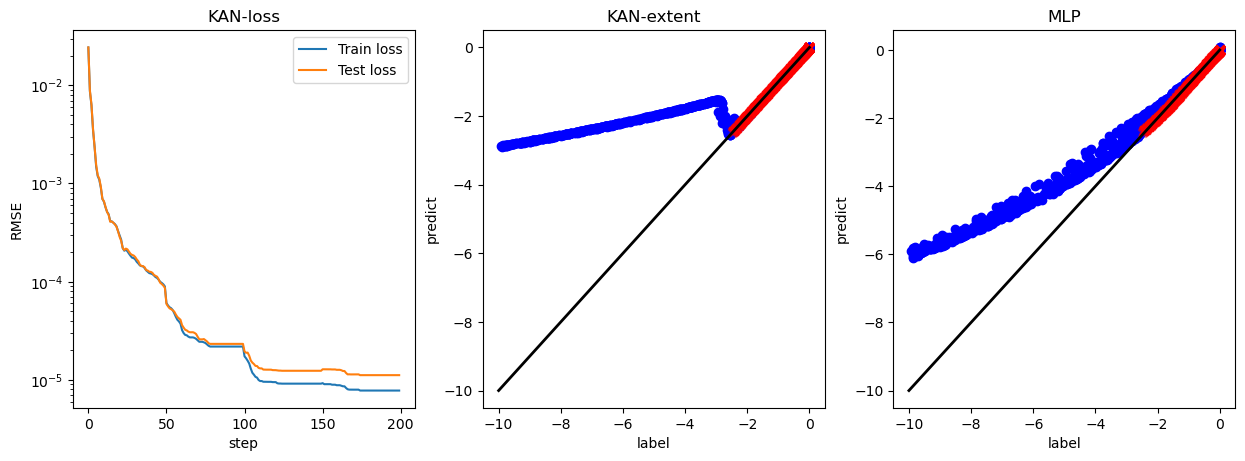

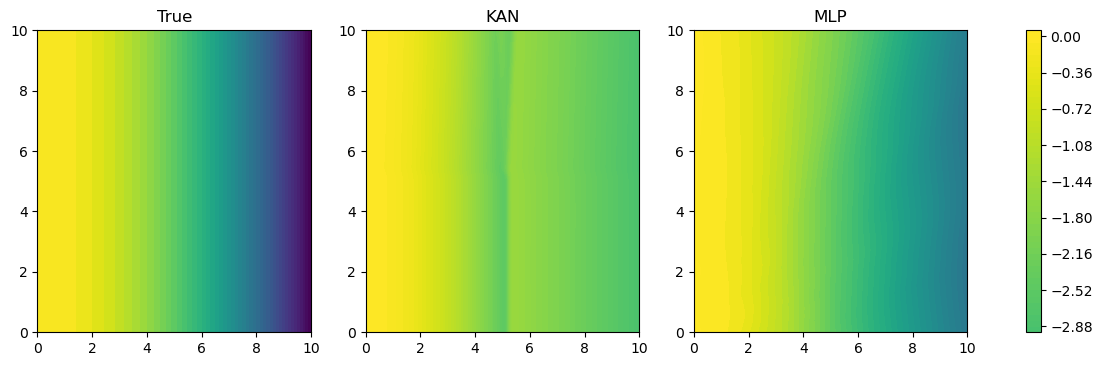

In [71]:
seeds = [random.randint(1, 2024) for _ in range(10)]
print(seeds)
for i in range(3):
    birth_dynamic(seeds[i])

# 4. mutual Dynamic

In [80]:
def mutual_dynamic(seed):
    # create mutual dynamic F+G
    f = lambda x: 0.1 + x[:, [0]] * (1 - x[:, [0]]/5) * (x[:, [0]] - 1)
    g = lambda x: (x[:, [0]] * x[:, [1]]) / (5 + 0.9 * x[:, [0]] + 0.1 * x[:, [1]])
    dataset = create_dataset(g, n_var=2, ranges=[0, 5], seed=seed)
    test_dataset = create_dataset(g, n_var=2, ranges=[0, 10], seed=seed)
    
    # 定义KAN模型
    grids = np.array([5, 10, 20, 30])  # ,100
    train_losses = []
    test_losses = []
    steps = 50
    k = 3
    for i in range(grids.shape[0]):
        if i == 0:
            model = KAN(width=[2,2,1], grid=grids[i], k=k, seed=seed)
        if i != 0:
            model = KAN(width=[2,2,1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])
        results = model.train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)  # default=30
        train_losses += results['train_loss']
        test_losses += results['test_loss']

    train_pred = model(dataset['train_input'])
    test_pred = model(test_dataset['test_input'])
    loss_fn = lambda x, y: torch.mean((x - y) ** 2)
    train_loss = torch.sqrt((loss_fn(train_pred, dataset['train_label'])))
    test_loss = torch.sqrt((loss_fn(test_pred, test_dataset['test_label'])))
    print('KAN : Train loss: ', train_loss.item(), ', Test loss: ', test_loss.item())

    # 定义 MLPRegressor 模型
    model_mlp = MLPRegressor(hidden_layer_sizes=(64, 64), activation='relu', solver='adam', max_iter=2000, random_state=0)
    model_mlp.fit(dataset['train_input'].cpu(), dataset['train_label'].cpu().ravel())
    train_pred_mlp = model_mlp.predict(dataset['train_input'].cpu())
    test_pred_mlp = model_mlp.predict(test_dataset['test_input'].cpu())
    loss_fn = lambda x, y: torch.mean((x - y) ** 2)
    train_loss = torch.sqrt((loss_fn(torch.tensor(train_pred_mlp).cuda(), dataset['train_label'])))
    test_loss = torch.sqrt((loss_fn(torch.tensor(test_pred_mlp).cuda(), test_dataset['test_label'])))
    print('MLP : Train loss: ', train_loss.item(), ', Test loss: ', test_loss.item())

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=100)
    ax1.plot(train_losses)
    ax1.plot(test_losses)
    ax1.legend(['Train loss', 'Test loss'])
    ax1.set_xlabel('step')
    ax1.set_ylabel('RMSE')
    ax1.set_yscale('log')
    ax1.set_title('KAN-loss')

    ax2.scatter(test_dataset['test_label'].cpu(), test_pred.cpu().detach().numpy(), marker='o', color='b')
    ax2.scatter(dataset['train_label'].cpu(), train_pred.cpu().detach().numpy(), marker='x', color='r', alpha=0.5)
    # 添加 y = x 的直线
    x_vals = np.linspace(0, 5, 100)
    ax2.plot(x_vals, x_vals, linestyle='-', color='black', linewidth=2, label='y = x')
    ax2.set_xlabel('label')
    ax2.set_ylabel('predict')
    ax2.set_title('KAN-extent')

    ax3.scatter(test_dataset['test_label'].cpu(), test_pred_mlp, marker='o', color='b')
    ax3.scatter(dataset['train_label'].cpu(), train_pred_mlp, marker='x', color='r', alpha=0.5)
    # 添加 y = x 的直线
    x_vals = np.linspace(0, 5, 100)
    ax3.plot(x_vals, x_vals, linestyle='-', color='black', linewidth=2, label='y = x')
    ax3.set_xlabel('label')
    ax3.set_ylabel('predict')
    ax3.set_title('MLP')
    plt.show()
    
    fig2, (ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), dpi=100)
    # 创建网格数据
    x = np.linspace(0, 10, 100)
    y = np.linspace(0, 10, 100)
    X_grid, Y_grid = np.meshgrid(x, y)
    # 计算每个网格点的输出值 Z
    grid_points = np.c_[X_grid.ravel(), Y_grid.ravel()]
    grid_points_torch = torch.tensor(grid_points, dtype=torch.float32)
    Z1 = g(grid_points_torch).numpy().reshape(X_grid.shape)
    Z2 = model(grid_points_torch.to("cuda")).cpu().detach().numpy().reshape(X_grid.shape)
    Z3 = model_mlp.predict(grid_points_torch.cpu()).reshape(X_grid.shape)
    contour1 = ax4.contourf(X_grid, Y_grid, Z1, levels=50, cmap='viridis', vmin=Z1.min(), vmax=Z1.max())
    ax4.set_title('True')
    contour2 = ax5.contourf(X_grid, Y_grid, Z2, levels=50, cmap='viridis', vmin=Z1.min(), vmax=Z1.max())
    ax5.set_title('KAN')
    contour3 = ax6.contourf(X_grid, Y_grid, Z3, levels=50, cmap='viridis', vmin=Z1.min(), vmax=Z1.max())
    ax6.set_title('MLP')
    # 添加一个共享的颜色条
    cbar = fig2.colorbar(contour2, ax=[ax4, ax5, ax6], location='right', shrink=1)
    plt.show()

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

[1730, 789, 1553, 1824, 862, 83, 531, 1978, 1048, 996]


train loss: 1.27e-03 | test loss: 1.29e-03 | reg: 7.08e+00 : 100%|██| 50/50 [00:25<00:00,  1.98it/s]
train loss: 2.88e-04 | test loss: 2.98e-04 | reg: 7.13e+00 : 100%|██| 50/50 [00:20<00:00,  2.48it/s]
train loss: 1.01e-04 | test loss: 1.23e-04 | reg: 7.12e+00 : 100%|██| 50/50 [00:21<00:00,  2.36it/s]
train loss: 7.57e-05 | test loss: 1.17e-04 | reg: 7.12e+00 : 100%|██| 50/50 [00:13<00:00,  3.82it/s]


KAN : Train loss:  7.571015885332599e-05 , Test loss:  0.6926851272583008
MLP : Train loss:  0.8588538797595545 , Test loss:  2.0712508889419374


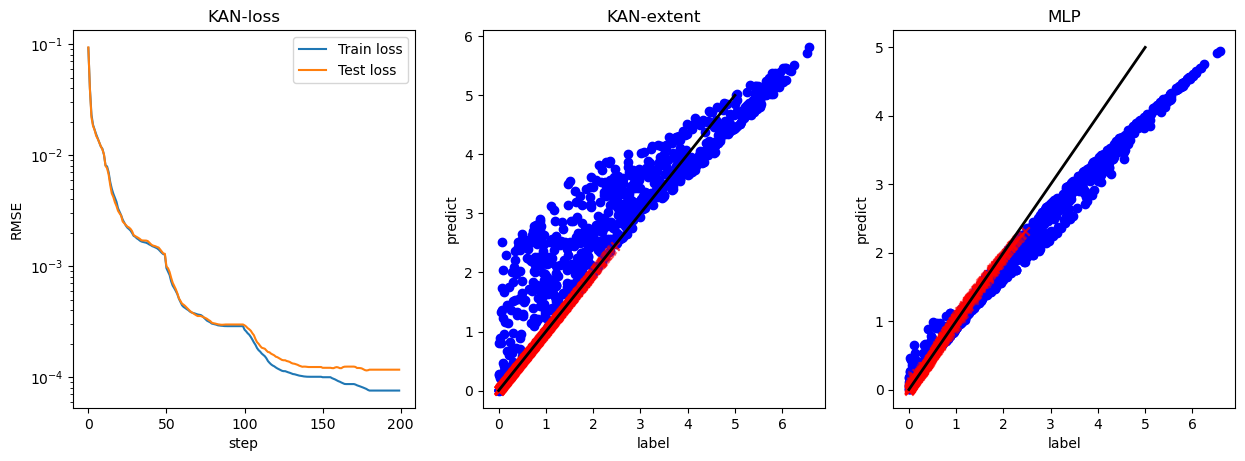

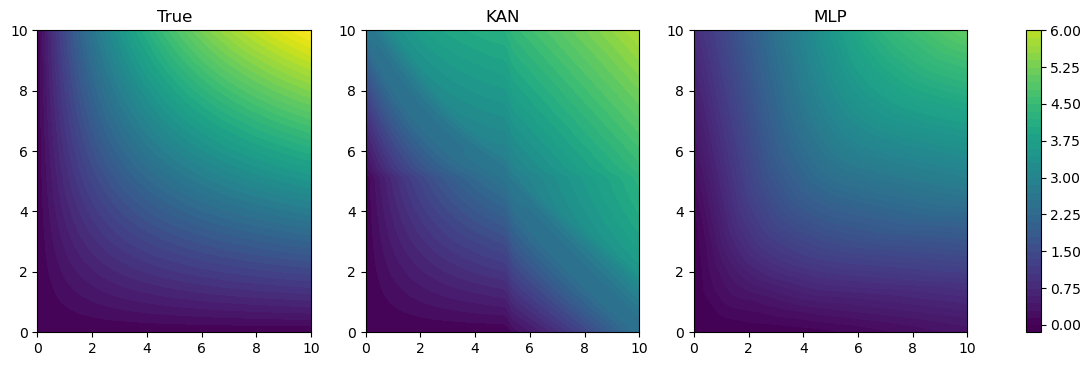

train loss: 8.27e-04 | test loss: 7.72e-04 | reg: 6.12e+00 : 100%|██| 50/50 [00:23<00:00,  2.17it/s]
train loss: 2.24e-04 | test loss: 2.14e-04 | reg: 6.12e+00 : 100%|██| 50/50 [00:23<00:00,  2.15it/s]
train loss: 1.03e-04 | test loss: 1.21e-04 | reg: 6.12e+00 : 100%|██| 50/50 [00:15<00:00,  3.24it/s]
train loss: 8.05e-05 | test loss: 1.19e-04 | reg: 6.12e+00 : 100%|██| 50/50 [00:16<00:00,  3.04it/s]


KAN : Train loss:  8.051795157371089e-05 , Test loss:  0.8744462728500366
MLP : Train loss:  0.8254709019888313 , Test loss:  2.1245135767341274


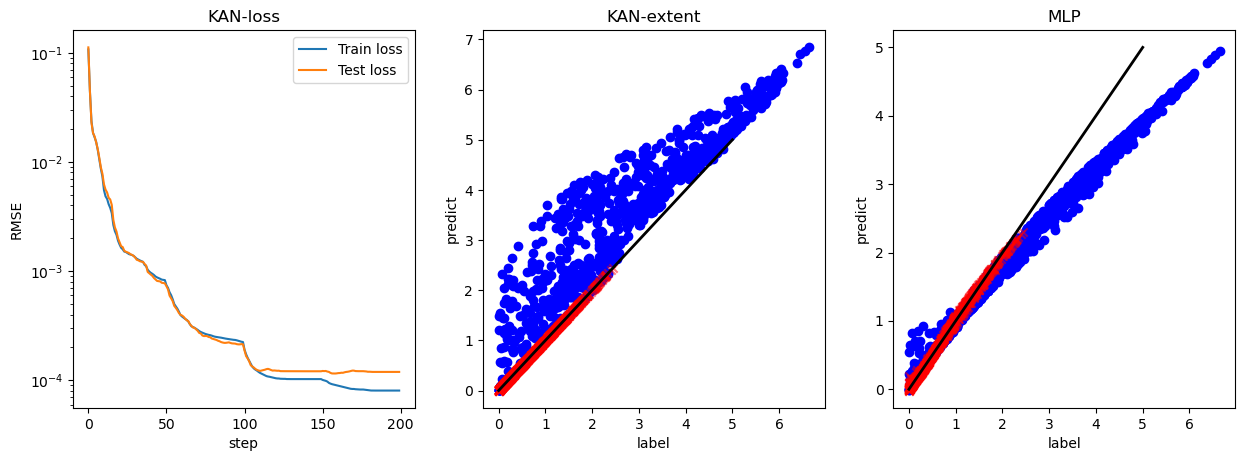

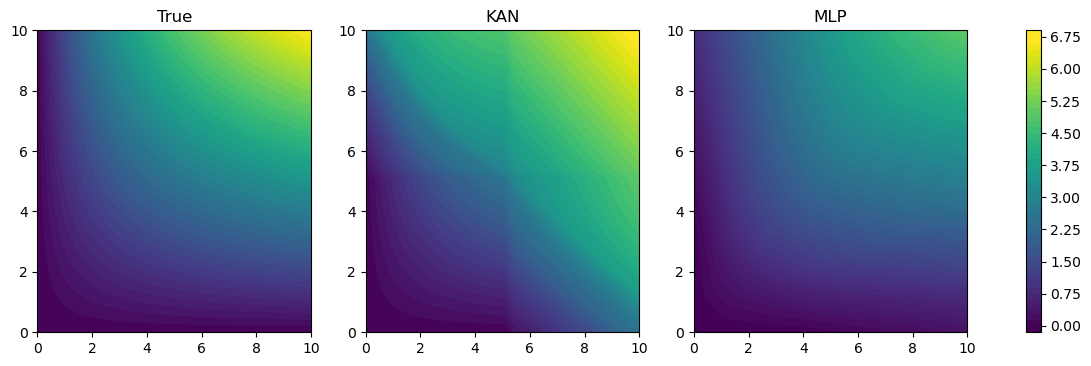

train loss: 1.04e-03 | test loss: 1.03e-03 | reg: 6.80e+00 : 100%|██| 50/50 [00:22<00:00,  2.19it/s]
train loss: nan | test loss: nan | reg: nan : 100%|█████████████████| 50/50 [00:22<00:00,  2.21it/s]
train loss: nan | test loss: nan | reg: nan : 100%|█████████████████| 50/50 [00:22<00:00,  2.21it/s]
train loss: nan | test loss: nan | reg: nan : 100%|█████████████████| 50/50 [00:22<00:00,  2.18it/s]


KAN : Train loss:  nan , Test loss:  nan
MLP : Train loss:  0.8630389736603582 , Test loss:  2.113068633382207


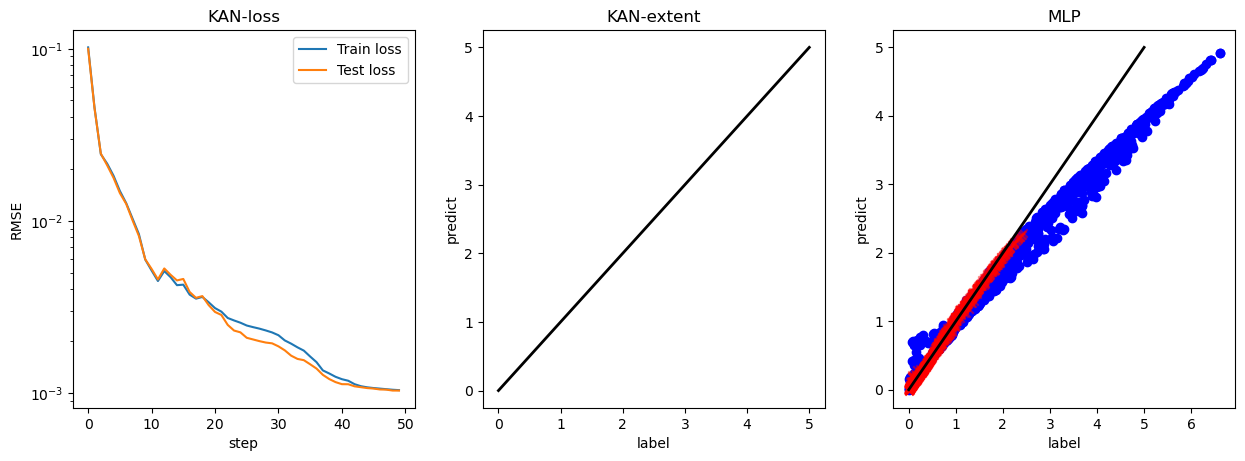

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


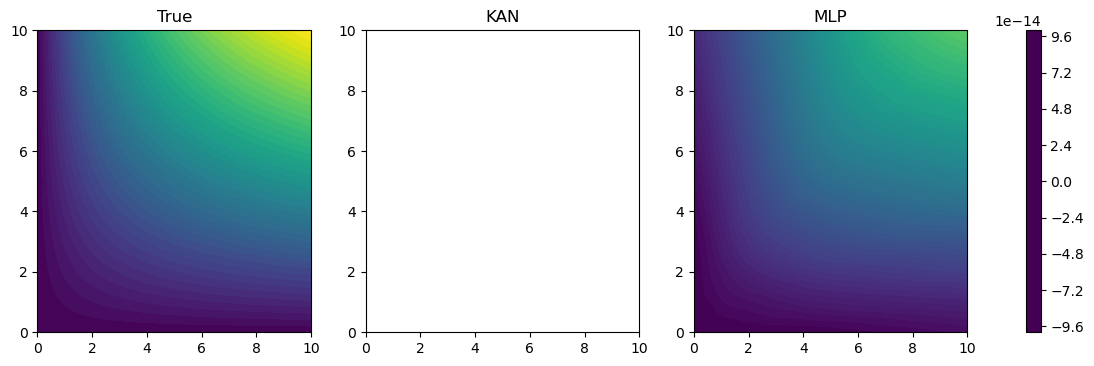

In [81]:
seeds = [random.randint(1, 2024) for _ in range(10)]
print(seeds)
for i in range(3):
    mutual_dynamic(seeds[i])